In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import HuberRegressor as hubreg
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import mixed_anova, anova, pairwise_tukey
from statsmodels.regression.mixed_linear_model import MixedLM


import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u
from STX3KO_analyses.single_cell_stats import CellStats 

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# add permuted field detection

# field appearance and shift


In [3]:
figdir = "/mnt/BigDisk/YMazeResults/neural/wta_comparisons"
os.makedirs(figdir,exist_ok=True)

In [4]:
sess = u.load_single_day(ko_mice[0],0)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [5]:
class LMM_CellStats:

    def __init__(self, days = np.arange(6), ts_key = 'spks'):

        '''


        :param days:
        :param ts_key:
        '''

        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.__dict__.update({'days': days, 'days_z': sp.stats.zscore(days), 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[],
                                'day_norm': [],
                                'dz': [],
                                'ko_x_day': [],
                                'lr':[], 
                                'novfam':[], 
                                'ko_x_novfam': [],
                                'novfam_x_day': [],
                                'speed':[],
                                'avg_std': [],
                                'avg_skewness': [],
                                'avg_kurtosis': [],
                                'skewness': [],
                                'max_counts': [],
                                'field_width': [],
                                'intercept': [],})
        self.fill_df()
#         self.df['speed'].apply(sp.stats.zscore)
        





    def fill_df(self):
        for mouse in self.ko_mice:
            for day, dz in zip(self.days,self.days_z):
                self.get_stats(u.load_single_day(mouse, day), 1, day, dz)
                
        for mouse in self.ctrl_mice:
            for day, dz in zip(self.days, self.days_z):
                self.get_stats(u.load_single_day(mouse,day),0, day, dz)
                
                
                

    def get_stats(self, sess, ko, day, dz, ts_key: str = 'spks'):
        '''

        :param sess:
        :param ts_key:
        :param fam:
        :return:
        '''
        
        for _arm, arm in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']==arm
            if sess.novel_arm == arm:
                cell_mask = sess.nov_place_cell_mask()
                nov = 1
            else:
                cell_mask = sess.fam_place_cell_mask()
                nov = 0



            trial_mat = sess.trial_matrices[ts_key][:, :, cell_mask]
            trial_mat = trial_mat[trial_mask, :, :]
            trial_mat[np.isnan(trial_mat)] = 1E-5
            
            
            
            
            avg_trial_mat = trial_mat.mean(axis=0, keepdims = True)


            inds = np.arange(0, trial_mat.shape[1])[np.newaxis, :, np.newaxis]

            avg_trial_mat_norm = avg_trial_mat / (np.nansum(avg_trial_mat, axis=1, keepdims=True) + 1E-5)
            avg_com = (avg_trial_mat_norm * inds).sum(axis=1, keepdims=True)
            avg_std = np.power((np.power(inds - avg_com, 2) * avg_trial_mat_norm).sum(axis=1, keepdims=True), .5)
            avg_skewness = (np.power((inds - avg_com) / (avg_std + 1E-5), 3) * avg_trial_mat_norm).sum(axis=1)
            avg_kurtosis = (np.power((inds - avg_com) / (avg_std + 1E-5), 4) * avg_trial_mat_norm).sum(axis=1)
            
            trial_mat_sm = sp.ndimage.filters.gaussian_filter1d(trial_mat, 3, axis=0)
            trial_mat_sm_norm = trial_mat_sm / (np.nansum(trial_mat_sm, axis=1, keepdims=True) + 1E-5)
        
            com = (trial_mat_sm_norm * inds).sum(axis=1, keepdims=True)
            std = np.power((np.power(inds - com, 2) * trial_mat_sm_norm).sum(axis=1, keepdims=True), .5)

            skewness = (np.power((inds - com) / (std + 1E-5), 3) * trial_mat_sm_norm).sum(axis=1)
            kurtosis = (np.power((inds - com) / (std + 1E-5), 4) * trial_mat_sm_norm).sum(axis=1)

            self.df = self.df.append({'mouse': sess.mouse, 
                                    'ko': ko, 
                                    'day': day,
                                    'day_norm': (day+1)/6.,
                                    'dz': dz,
                                    'ko_x_day': ko*(day+1)/6.,
                                    'lr': _arm, 
                                    'novfam': nov, 
                                    'ko_x_novfam': ko*nov,
                                    'novfam_x_day': nov*(day+1)/6.,
                                    'avg_std': avg_std.mean(),
                                    'avg_skewness': avg_skewness.mean(),
                                    'skewness': skewness.mean(axis=0).mean(),
                                    'avg_kurtosis': avg_kurtosis.mean(),
                                    'max_counts': stx.spatial_analyses.max_counts(avg_trial_mat[0, :, :]).mean(),
                                    'field_width': np.nanmean(stx.spatial_analyses.field_width(avg_trial_mat[0, :, :])),
                                    'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0),axis=0),
                                    'intercept':1}, ignore_index=True)
            

        

       


        

In [6]:
cell_stats = LMM_CellStats()

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

In [7]:
lmm_res = MixedLM(cell_stats.df['avg_std'], cell_stats.df[['ko', 
                                                           'day_norm', 
                                                           'novfam', 
                                                           'lr', 
                                                           'ko_x_day', 
                                                           'ko_x_novfam', 
                                                           'novfam_x_day',
                                                           'speed',
                                                           'intercept']], cell_stats.df['mouse'], exog_re = cell_stats.df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: avg_std 
No. Observations:  192     Method:             REML    
No. Groups:        16      Scale:              0.0793  
Min. group size:   12      Log-Likelihood:     -51.6567
Max. group size:   12      Converged:          Yes     
Mean group size:   12.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
ko            0.054    0.114  0.475 0.635 -0.169  0.277
day_norm     -0.327    0.167 -1.954 0.051 -0.655  0.001
novfam       -0.619    0.100 -6.220 0.000 -0.815 -0.424
lr            0.081    0.041  1.966 0.049  0.000  0.161
ko_x_day      0.155    0.226  0.684 0.494 -0.289  0.598
ko_x_novfam   0.217    0.082  2.649 0.008  0.056  0.378
novfam_x_day  0.230    0.143  1.611 0.107 -0.050  0.510
speed        -1.104    0.465 -2.375 0.018 -2.015 -0.193
i

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


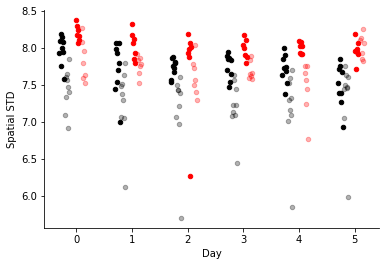

In [8]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Spatial STD')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "avg_std_summary.pdf"))

In [9]:
# lmm_res = MixedLM(cell_stats.df['max_counts'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

lmm_res = MixedLM(cell_stats.df['max_counts'], cell_stats.df[['ko', 
                                                              'day_norm', 
                                                              'novfam', 
                                                              'lr', 
                                                              'ko_x_day', 
                                                              'ko_x_novfam', 
                                                              'novfam_x_day',
                                                              'speed',
                                                              'intercept']], cell_stats.df['mouse']) #, exog_re = cell_stats.df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: max_counts
No. Observations: 192     Method:             REML      
No. Groups:       16      Scale:              0.0477    
Min. group size:  12      Log-Likelihood:     -8.1192   
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.012    0.125  0.095 0.925 -0.234  0.258
day_norm      -0.348    0.095 -3.668 0.000 -0.535 -0.162
novfam         0.056    0.077  0.721 0.471 -0.096  0.207
lr            -0.079    0.032 -2.496 0.013 -0.142 -0.017
ko_x_day       0.041    0.112  0.365 0.715 -0.179  0.260
ko_x_novfam    0.115    0.064  1.818 0.069 -0.009  0.240
novfam_x_day  -0.077    0.111 -0.695 0.487 -0.294  0.140
speed         -2.412    0.437 -5.523 0.00

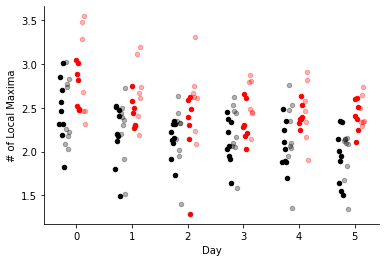

In [10]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('# of Local Maxima')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "max_counts_summary.pdf"))

In [11]:
# lmm_res = MixedLM(cell_stats.df['field_width'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

lmm_res = MixedLM(cell_stats.df['field_width'], cell_stats.df[['ko', 
                                                               'day', 
                                                               'novfam', 
                                                               'lr', 
                                                               'ko_x_day', 
                                                               'ko_x_novfam', 
                                                               'novfam_x_day',
                                                               'speed',
                                                               'intercept']],cell_stats.df['mouse'], exog_re = cell_stats.df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_width
No. Observations: 192     Method:             REML       
No. Groups:       16      Scale:              0.0846     
Min. group size:  12      Log-Likelihood:     -61.6931   
Max. group size:  12      Converged:          Yes        
Mean group size:  12.0                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             -0.367    0.120 -3.066 0.002 -0.601 -0.132
day            -0.021    0.032 -0.665 0.506 -0.084  0.041
novfam         -0.318    0.103 -3.086 0.002 -0.519 -0.116
lr              0.299    0.042  7.050 0.000  0.216  0.382
ko_x_day       -0.195    0.264 -0.736 0.462 -0.712  0.323
ko_x_novfam    -0.083    0.085 -0.976 0.329 -0.249  0.083
novfam_x_day    0.382    0.148  2.590 0.010  0.093  0.671
speed           3.941   

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [12]:
res = mixed_anova(data = cell_stats.df[cell_stats.df['novfam']==1], dv= 'field_width', between = 'ko', within = 'day', subject = 'mouse')
print(res)
print(res['p-unc'].iloc[0])

        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0           ko  22.725388    1   14  22.725388  19.324054  0.000610  0.579883   
1          day   1.694244    5   70   0.338849   5.261726  0.000369  0.273170   
2  Interaction   0.577213    5   70   0.115443   1.792620  0.125604  0.113510   

       eps  
0      NaN  
1  0.73854  
2      NaN  
0.0006095902666211737


In [13]:
res = mixed_anova(data = cell_stats.df[cell_stats.df['novfam']==0], dv= 'field_width', between = 'ko', within = 'day', subject = 'mouse')
print(res)
print(res['p-unc'].iloc[0])

        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0           ko  18.394581    1   14  18.394581  32.770501  0.000053  0.700666   
1          day   0.783020    5   70   0.156604   3.050045  0.015078  0.178888   
2  Interaction   0.238555    5   70   0.047711   0.929227  0.467466  0.062242   

       eps  
0      NaN  
1  0.68686  
2      NaN  
5.253852984884399e-05


In [14]:
cell_stats.df[(cell_stats.df['novfam']==0) & (cell_stats.df['mouse']=='mCherry9') & (cell_stats.df['day']==0)]

,mouse,ko,day,day_norm,dz,ko_x_day,lr,novfam,ko_x_novfam,novfam_x_day,speed,avg_std,avg_skewness,avg_kurtosis,skewness,max_counts,field_width,intercept
181,mCherry9,0.0,0.0,0.166667,-1.46385,0.0,1.0,0.0,0.0,0.0,0.373462,7.584856,-0.122823,2.983508,-0.131809,1.826464,5.958005,1.0


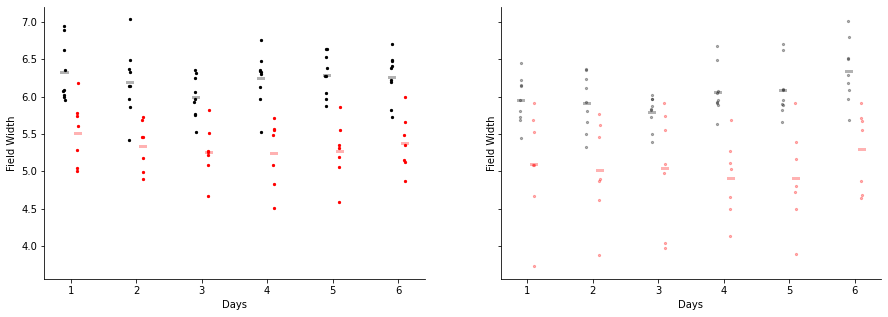

In [15]:
fig, ax = plt.subplots(1,2, figsize=[15,5],sharey=True)


for day in range(6):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['day']==day) & (cell_stats.df['novfam']==0)
    frac = np.array([cell_stats.df['field_width'].loc[mask & (cell_stats.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[0].scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=5)
    ax[0].plot(5*day  -.5 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['day']==day) & (cell_stats.df['novfam']==1)
    frac = np.array([cell_stats.df['field_width'].loc[mask & (cell_stats.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[1].scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=5,alpha = .3)
    ax[1].plot(5*day  -.5 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['day']==day) & (cell_stats.df['novfam']==0)
    frac = np.array([cell_stats.df['field_width'].loc[mask & (cell_stats.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[0].scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=5)
    ax[0].plot(5*day  +.5 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['day']==day) & (cell_stats.df['novfam']==1)
    frac = np.array([cell_stats.df['field_width'].loc[mask & (cell_stats.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[1].scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=5, alpha = .3)
    ax[1].plot(5*day  +.5 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    

for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("Field Width")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
# ax.set_ylabel('Field Width')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "field_width_summary.pdf"))

6.081305933846537 2.8314569931240582e-05
3.3343135813572675 0.0008551019694724832


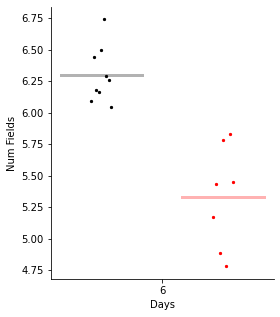

In [21]:
fig, ax = plt.subplots(figsize=[4,5],sharey=True)


day =5
mask = (cell_stats.df['ko']==0) & (cell_stats.df['day']==day) 
ctrl_frac = np.array([cell_stats.df['field_width'].loc[mask & (cell_stats.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
ax.scatter(5*day-.3 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_frac, color = 'black', s=5)
ax.plot(5*day  -.3 + np.array([-0.2,0.2]), ctrl_frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)

mask = (cell_stats.df['ko']==1) & (cell_stats.df['day']==day) 
ko_frac = np.array([cell_stats.df['field_width'].loc[mask & (cell_stats.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
ax.scatter(5*day+.3 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_frac, color = 'red', s=5)
ax.plot(5*day  +.3 + np.array([-0.2,0.2]), ko_frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)


t,p = sp.stats.ttest_ind(ctrl_frac,ko_frac)
print(t,p)
t,p = sp.stats.ranksums(ctrl_frac,ko_frac)
print(t,p)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("Num Fields")
ax.set_xticks(5*np.arange(5,6))
ax.set_xticklabels(np.arange(6,7))
    
fig.savefig(os.path.join(figdir,"field_width_summary_short.pdf"))

In [14]:
# lmm_res = MixedLM(cell_stats.df['avg_skewness'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

lmm_res = MixedLM(cell_stats.df['avg_skewness'], cell_stats.df[['ko', 
                                                                'day', 
                                                                'novfam', 
                                                                'lr', 
                                                                'ko_x_day', 
                                                                'ko_x_novfam', 
                                                                'novfam_x_day',
                                                                'speed',
                                                                'intercept']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_skewness
No. Observations: 192     Method:             REML        
No. Groups:       16      Scale:              0.0048      
Min. group size:  12      Log-Likelihood:     198.7414    
Max. group size:  12      Converged:          Yes         
Mean group size:  12.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              -0.016    0.044 -0.367 0.714 -0.102  0.070
day             -0.000    0.005 -0.045 0.964 -0.010  0.010
novfam          -0.050    0.024 -2.044 0.041 -0.098 -0.002
lr              -0.006    0.010 -0.576 0.565 -0.026  0.014
ko_x_day         0.043    0.035  1.219 0.223 -0.026  0.113
ko_x_novfam      0.080    0.020  4.006 0.000  0.041  0.120
novfam_x_day     0.027    0.035  0.771 0.441 -0.042  0.096
speed   

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


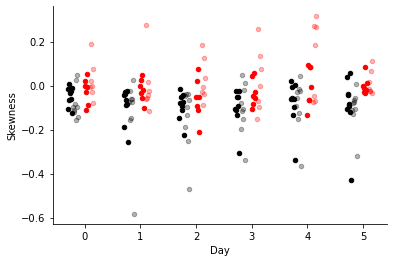

In [15]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_skewness'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['avg_skewness'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_skewness'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['avg_skewness'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Skewness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir, "skewness_summary.pdf"))

In [16]:
# lmm_res = MixedLM(cell_stats.df['avg_kurtosis'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

lmm_res = MixedLM(cell_stats.df['avg_kurtosis'], cell_stats.df[['ko', 
                                                                'dz', 
                                                                'novfam', 
                                                                'lr', 
                                                                'ko_x_day', 
                                                                'ko_x_novfam', 
                                                                'novfam_x_day',
                                                                'speed',
                                                                'intercept']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_kurtosis
No. Observations: 192     Method:             REML        
No. Groups:       16      Scale:              0.1061      
Min. group size:  12      Log-Likelihood:     -82.7180    
Max. group size:  12      Converged:          Yes         
Mean group size:  12.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              -0.044    0.188 -0.236 0.814 -0.413  0.325
dz               0.162    0.040  4.010 0.000  0.083  0.241
novfam           0.795    0.115  6.894 0.000  0.569  1.021
lr               0.034    0.047  0.717 0.473 -0.059  0.127
ko_x_day        -0.211    0.167 -1.265 0.206 -0.539  0.116
ko_x_novfam     -0.225    0.095 -2.373 0.018 -0.411 -0.039
novfam_x_day    -0.346    0.165 -2.094 0.036 -0.670 -0.022
speed   

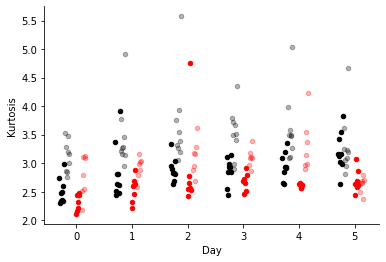

In [17]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Kurtosis')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "kurtosis_summary.pdf"))

In [19]:
fam_cell_stats = CellStats(fam=True)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

ValueError: Subject IDs cannot overlap between groups: each group in `ko_ctrl` must have a unique set of subject IDs, e.g. group1 = [1, 2, 3, ..., 10] and group2 = [11, 12, 13, ..., 20]

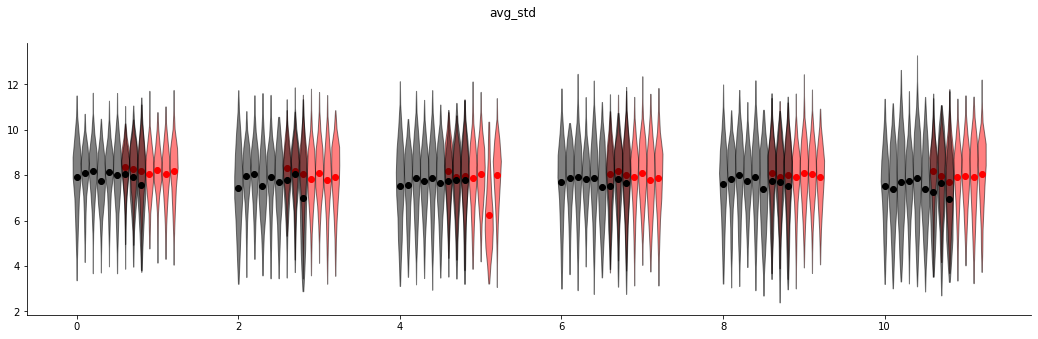

In [18]:
fig,ax = fam_cell_stats.violin_plots('avg_std')
fam_cell_stats.mixed_anova('avg_std')
# fig.savefig(os.path.join(figdir, 'fam_avg_std_violin.pdf'),format = 'pdf')

In [ ]:
fig, ax = fam_cell_stats.combined_hist('avg_std', cumulative=False, smooth=False, fill = True)
fig.savefig(os.path.join(figdir, 'fam_avg_std_hist.pdf'),format = 'pdf')
fig, ax = fam_cell_stats.combined_hist('avg_std', cumulative=True, smooth=True, fill = False)

fig.savefig(os.path.join(figdir, 'fam_avg_std_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0      ko_ctrl  18.394581    1   14  18.394581  32.770501  0.000053  0.700666   
1          day   0.783020    5   70   0.156604   3.050045  0.015078  0.178888   
2  Interaction   0.238555    5   70   0.047711   0.929227  0.467466  0.062242   

       eps  
0      NaN  
1  0.68686  
2      NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se          T  p-tukey    hedges
0  0  1  5.335721  6.218108 -0.882387  0.074947 -11.773451    0.001 -2.402866
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  5.517779  6.328318 -0.810539  0.207491 -3.906376  0.001583 -1.861249
Day 1
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  5.341539  6.192316 -0.850777  0.201554 -4.221094    0.001 -2.011201
Day 2
   A  B   mean(A)   mean(B)      diff        se         T  p

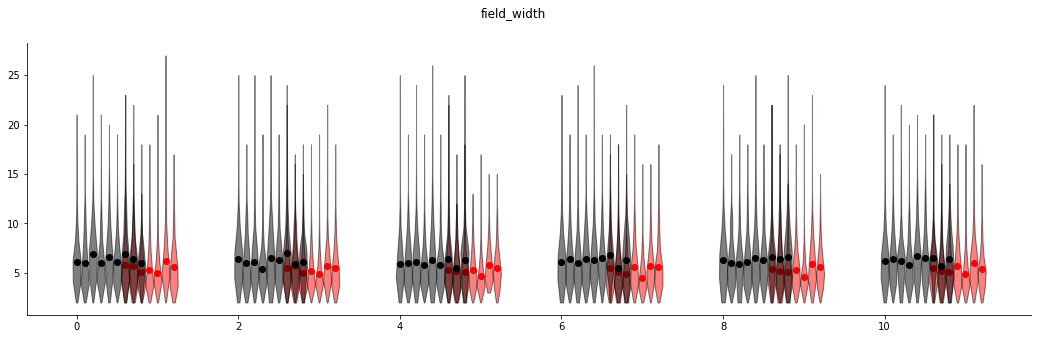

In [20]:
fig,ax = fam_cell_stats.violin_plots('field_width')
fam_cell_stats.mixed_anova('field_width')
fig.savefig(os.path.join(figdir, 'fam_field_width_violin.pdf'),format = 'pdf')

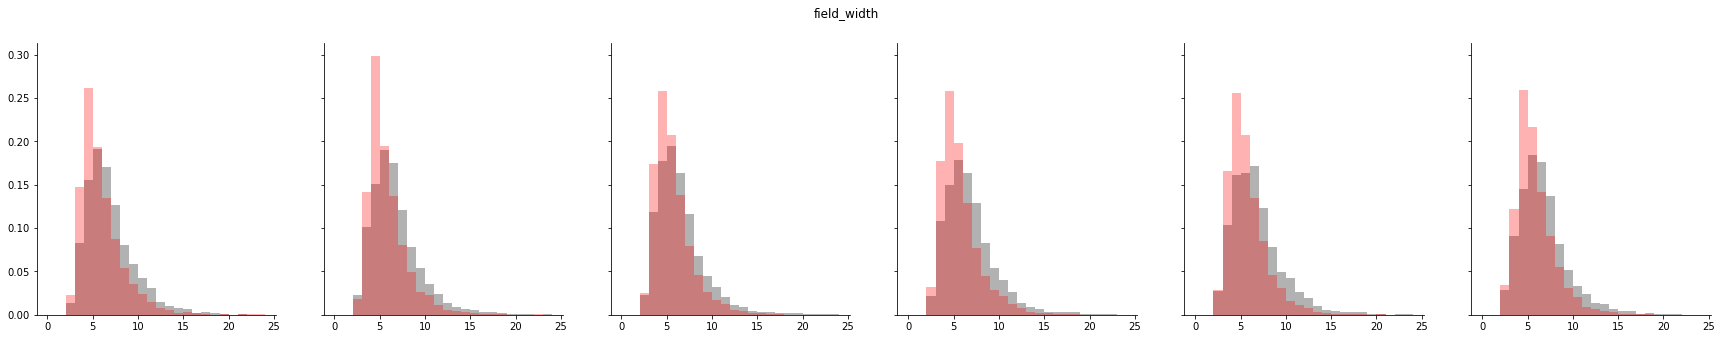

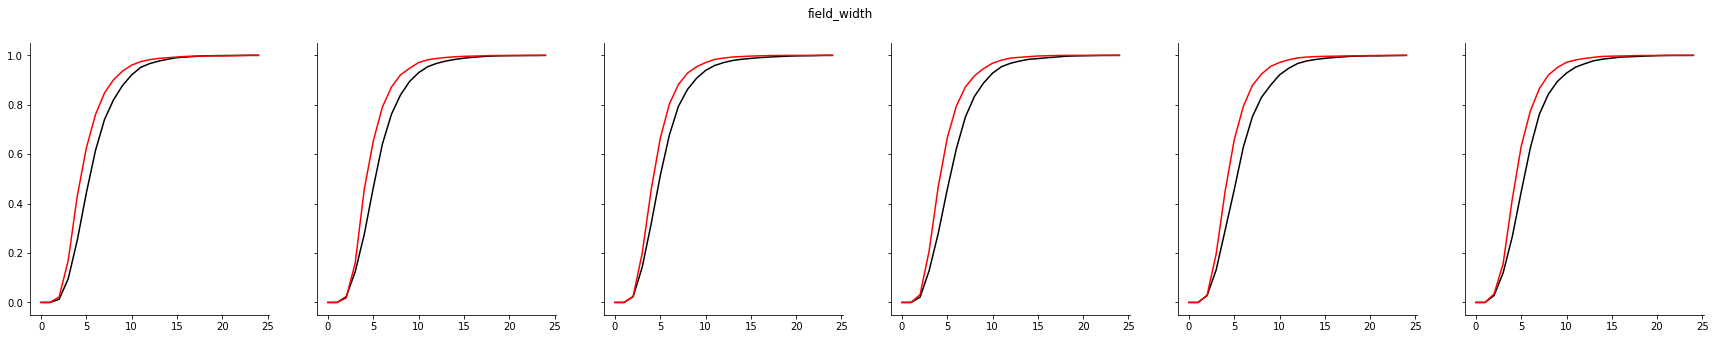

In [21]:
fig, ax = fam_cell_stats.combined_hist('field_width', cumulative=False, smooth=False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'fam_field_width_hist.pdf'),format = 'pdf')

fig, ax = fam_cell_stats.combined_hist('field_width', cumulative=True, smooth=True, fill= False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'fam_field_width_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  5.836834    1   14  5.836834  16.228589  0.001245  0.536862   
1          day  0.528707    5   70  0.105741   3.523775  0.006723  0.201085   
2  Interaction  0.231663    5   70  0.046333   1.544009  0.187478  0.099331   

        eps  
0       NaN  
1  0.692156  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.365175  1.868122  0.497053  0.059629  8.335718    0.001  1.701252
PostHov Tukey on each day
Day 0
   A  B   mean(A)  mean(B)      diff        se         T   p-tukey  hedges
0  0  1  2.454367  2.07742  0.376947  0.128895  2.924458  0.011092  1.3934
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.323649  1.852864  0.470785  0.137105  3.433741  0.004033  1.636055
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey   

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  5.836834    1   14  5.836834  16.228589  0.001245  0.536862   
 1          day  0.528707    5   70  0.105741   3.523775  0.006723  0.201085   
 2  Interaction  0.231663    5   70  0.046333   1.544009  0.187478  0.099331   
 
         eps  
 0       NaN  
 1  0.692156  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  2.365175  1.868122  0.497053  0.059629  8.335718    0.001  1.701252,
 'day_tukey': [   A  B   mean(A)  mean(B)      diff        se         T   p-tukey  hedges
  0  0  1  2.454367  2.07742  0.376947  0.128895  2.924458  0.011092  1.3934,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  2.323649  1.852864  0.470785  0.137105  3.433741  0.004033  1.636055,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  2.268815  1.88

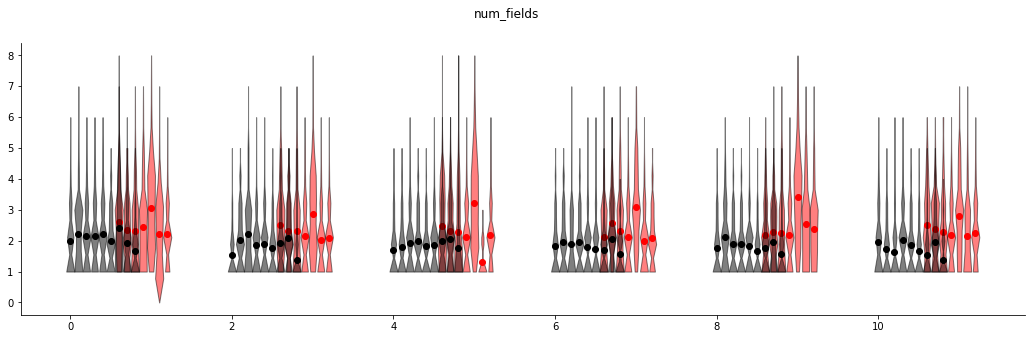

In [22]:
fig,ax = fam_cell_stats.violin_plots('num_fields')
fam_cell_stats.mixed_anova('num_fields')
# fig.savefig(os.path.join(figdir, 'fam_max_counts_violin.pdf'),format = 'pdf')

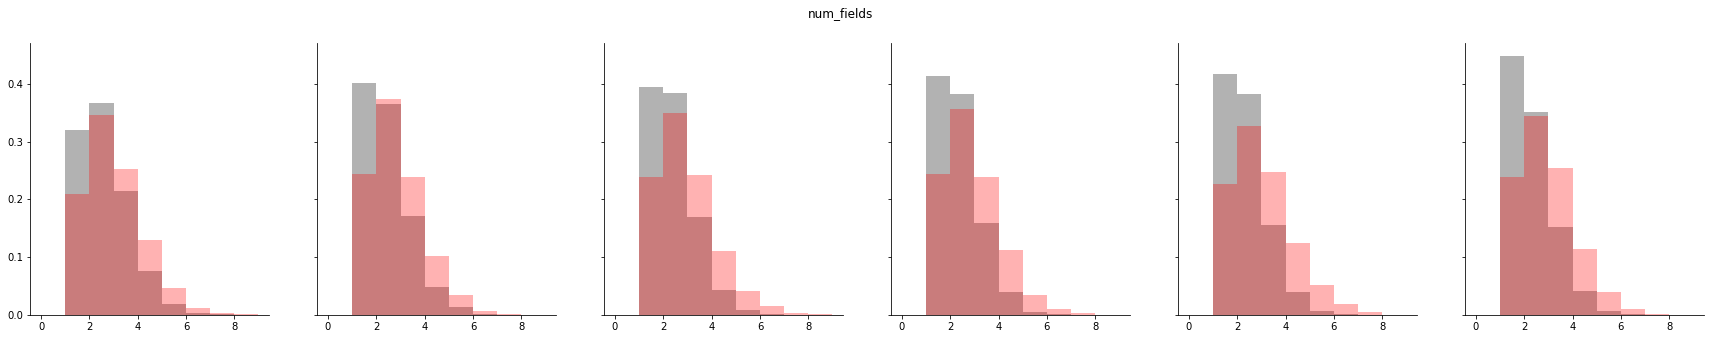

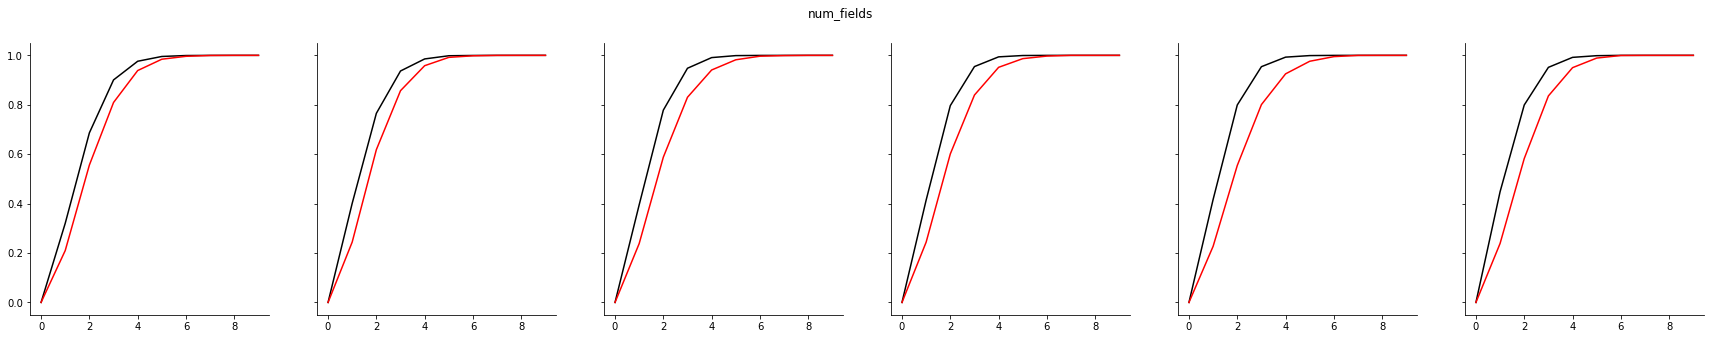

In [30]:
fig, ax = fam_cell_stats.combined_hist('num_fields', cumulative=False, smooth=False, bins = np.arange(0,10))
fig.savefig(os.path.join(figdir, 'fam_num_fields_hist.pdf'),format = 'pdf')
fig, ax = fam_cell_stats.combined_hist('num_fields', cumulative=True, smooth=True, fill = False, bins = np.arange(0,10))
fig.savefig(os.path.join(figdir, 'fam_num_fields_cumhist.pdf'),format = 'pdf')

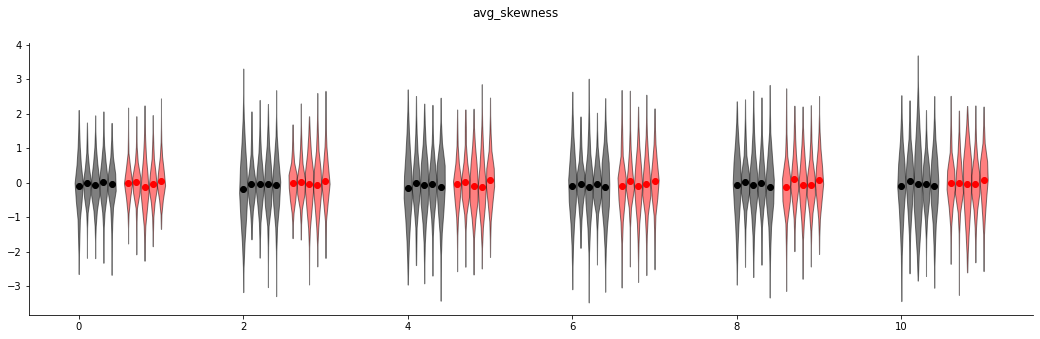

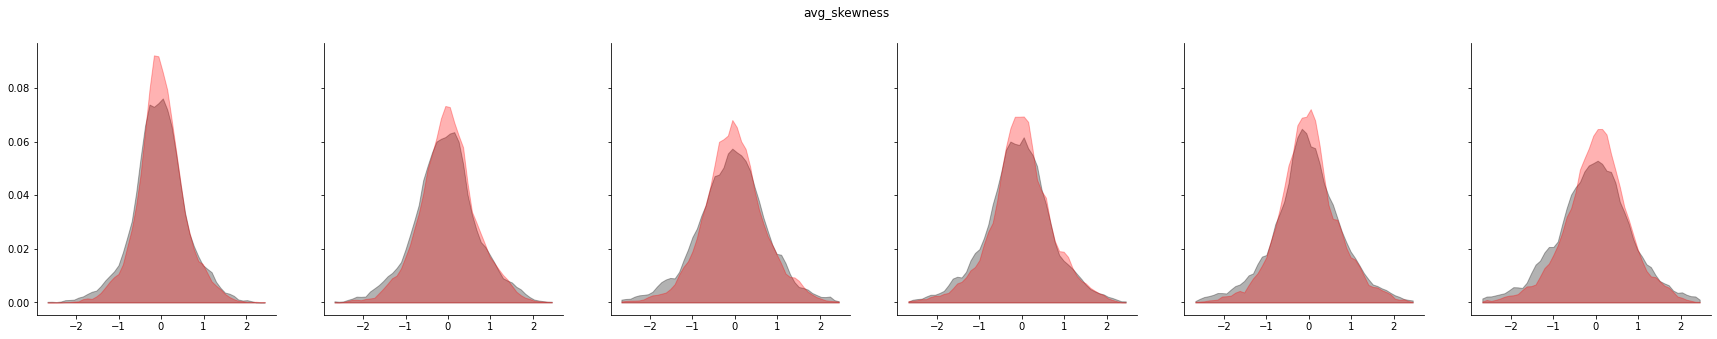

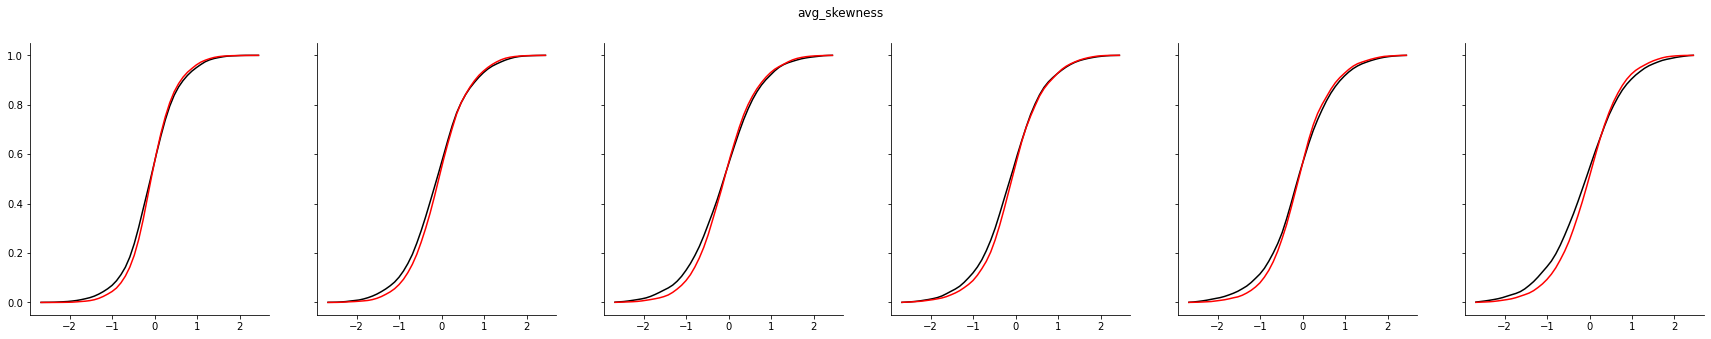

In [42]:
fig,ax = fam_cell_stats.violin_plots('avg_skewness')
# fam_cell_stats.mixed_anova('avg_skewness')

fig, ax = fam_cell_stats.combined_hist('avg_skewness', cumulative=False, smooth=True, fill = True)
fig.savefig(os.path.join(figdir, 'fam_avg_skewness.pdf'),format = 'pdf')
fig, ax = fam_cell_stats.combined_hist('avg_skewness', cumulative=True, smooth=True, fill = False)

fig.savefig(os.path.join(figdir, 'fam_avg_skewness_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F         p-unc  \
0      ko_ctrl  1.068538    1    8  1.068538   6.490086  3.430445e-02   
1          day  1.647648    5   40  0.329530  13.120973  1.391515e-07   
2  Interaction  0.094993    5   40  0.018999   0.756469  5.864374e-01   

        np2       eps  
0  0.447898       NaN  
1  0.621230  0.477734  
2  0.086390       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff       se         T  p-tukey    hedges
0  0  1  2.534523  2.801423 -0.266901  0.06835 -3.904926    0.001 -0.995153
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.251932  2.445312 -0.193381  0.101779 -1.900007  0.093966 -1.085379
Day 1
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0  0  1  2.451096  2.749516 -0.29842  0.188064 -1.586802  0.151218 -0.906461
Day 2
   A  B   mean(A)   mean(B)      diff       se      

{'anova':         Source        SS  DF1  DF2        MS          F         p-unc  \
 0      ko_ctrl  1.068538    1    8  1.068538   6.490086  3.430445e-02   
 1          day  1.647648    5   40  0.329530  13.120973  1.391515e-07   
 2  Interaction  0.094993    5   40  0.018999   0.756469  5.864374e-01   
 
         np2       eps  
 0  0.447898       NaN  
 1  0.621230  0.477734  
 2  0.086390       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff       se         T  p-tukey    hedges
 0  0  1  2.534523  2.801423 -0.266901  0.06835 -3.904926    0.001 -0.995153,
 'day_tukey': [   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  2.251932  2.445312 -0.193381  0.101779 -1.900007  0.093966 -1.085379,
     A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
  0  0  1  2.451096  2.749516 -0.29842  0.188064 -1.586802  0.151218 -0.906461,
     A  B   mean(A)   mean(B)      diff       se        T   p-tukey    hedges
  0  0  1

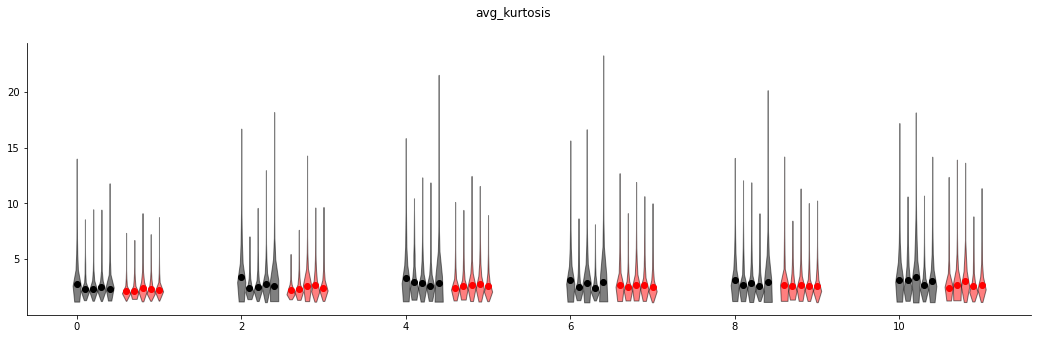

In [24]:
fig,ax = fam_cell_stats.violin_plots('avg_kurtosis')
fam_cell_stats.mixed_anova('avg_kurtosis')

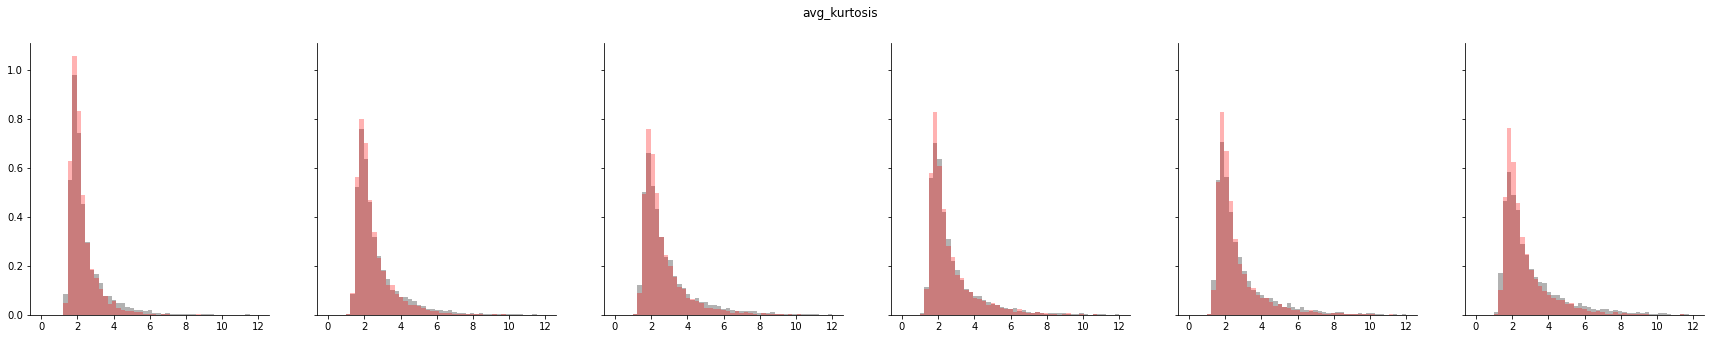

In [25]:
fig, ax = fam_cell_stats.combined_hist('avg_kurtosis', cumulative=False, smooth=False, bins=np.linspace(0,12))

/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:334: RuntimeWarning: Mean of empty slice
  ko_mu, ko_sem = np.nanmean(ko_mu_arr, axis=0), sp.stats.sem(ko_mu_arr, axis=0, nan_policy='omit')
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:335: RuntimeWarning: Mean of empty slice
  ctrl_mu, ctrl_sem = np.nanmean(ctrl_mu_arr, axis=0), sp.stats.sem(ctrl_mu_arr, axis=0, nan_policy='omit')


(<Figure size 2160x720 with 12 Axes>,
 array([[<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>],
        [<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>]], dtype=object))

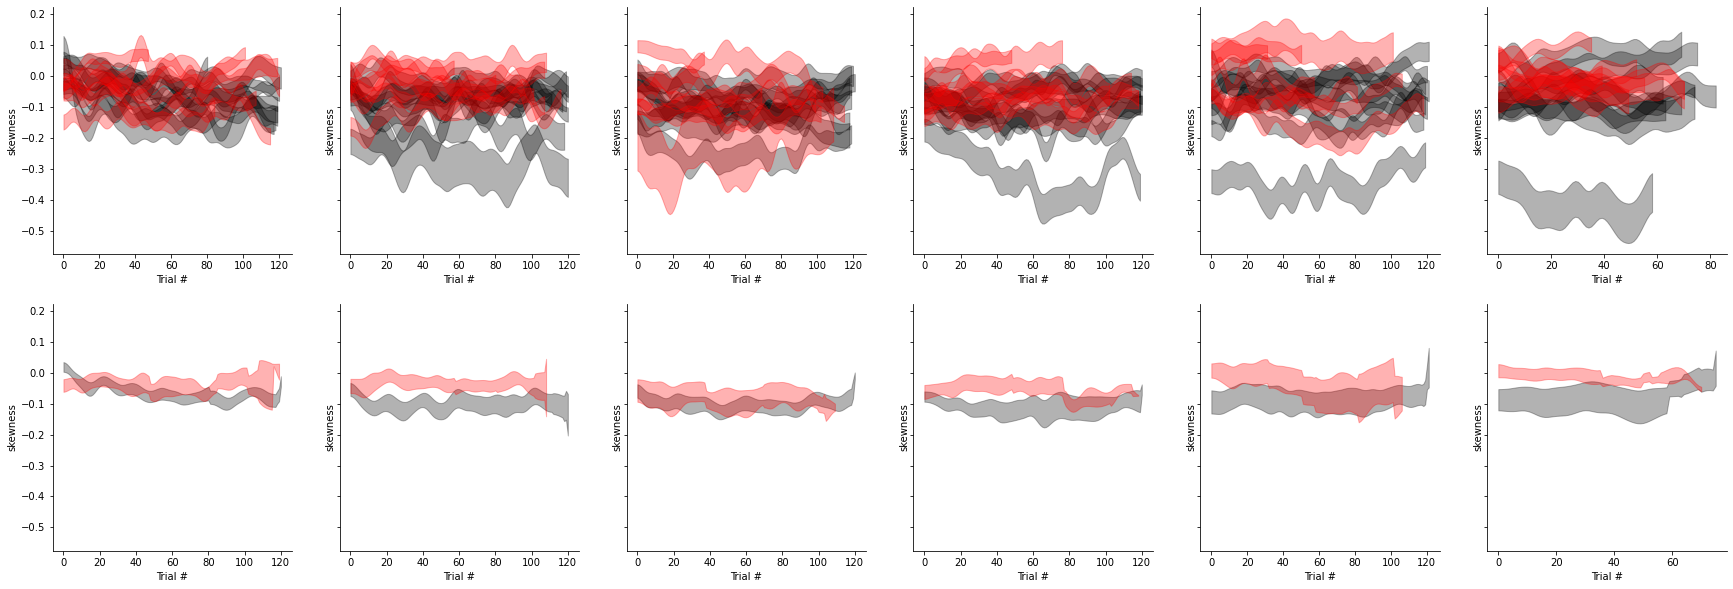

In [24]:
fam_cell_stats.across_trial_plot('skewness')

In [25]:
nov_cell_stats = CellStats(fam=False)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  2.722317    1    8  2.722317  18.386612  0.002659  0.696816   
1          day  0.707231    5   40  0.141446   5.698823  0.000464  0.416008   
2  Interaction  0.127781    5   40  0.025556   1.029653  0.413430  0.114030   

        eps  
0       NaN  
1  0.570457  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  7.803159  7.377145  0.426014  0.058842  7.239927    0.001  1.845064
PostHov Tukey on each day
Day 0
   A  B   mean(A)  mean(B)      diff        se         T   p-tukey    hedges
0  0  1  7.945582  7.45417  0.491412  0.155399  3.162261  0.013351  1.806442
Day 1
   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
0  0  1  7.764424  7.348038  0.416386  0.10945  3.804352  0.005204  2.173237
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey 

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  2.722317    1    8  2.722317  18.386612  0.002659  0.696816   
 1          day  0.707231    5   40  0.141446   5.698823  0.000464  0.416008   
 2  Interaction  0.127781    5   40  0.025556   1.029653  0.413430  0.114030   
 
         eps  
 0       NaN  
 1  0.570457  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  7.803159  7.377145  0.426014  0.058842  7.239927    0.001  1.845064,
 'day_tukey': [   A  B   mean(A)  mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  7.945582  7.45417  0.491412  0.155399  3.162261  0.013351  1.806442,
     A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
  0  0  1  7.764424  7.348038  0.416386  0.10945  3.804352  0.005204  2.173237,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  7.726642  7.

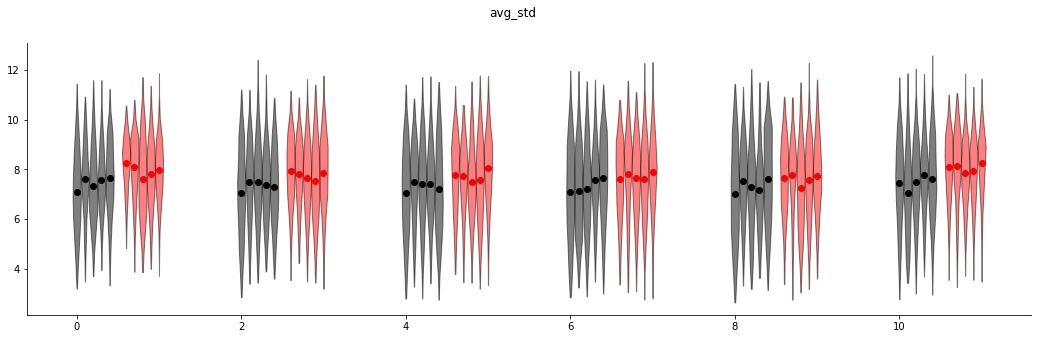

In [34]:
fig,ax = nov_cell_stats.violin_plots('avg_std')
nov_cell_stats.mixed_anova('avg_std')
# fig.savefig(os.path.join(figdir, 'nov_avg_std_violin.pdf'),format = 'pdf')

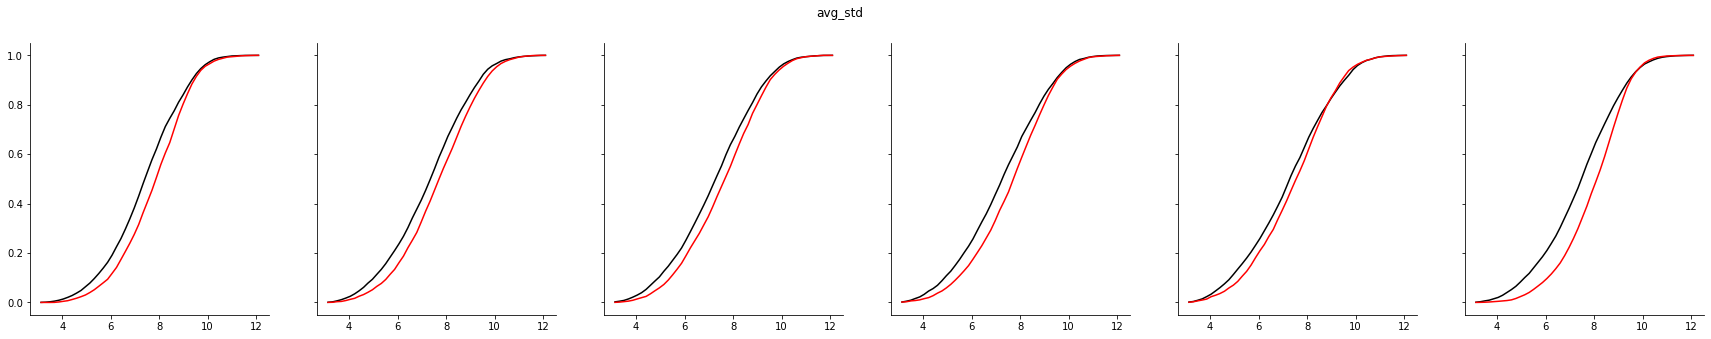

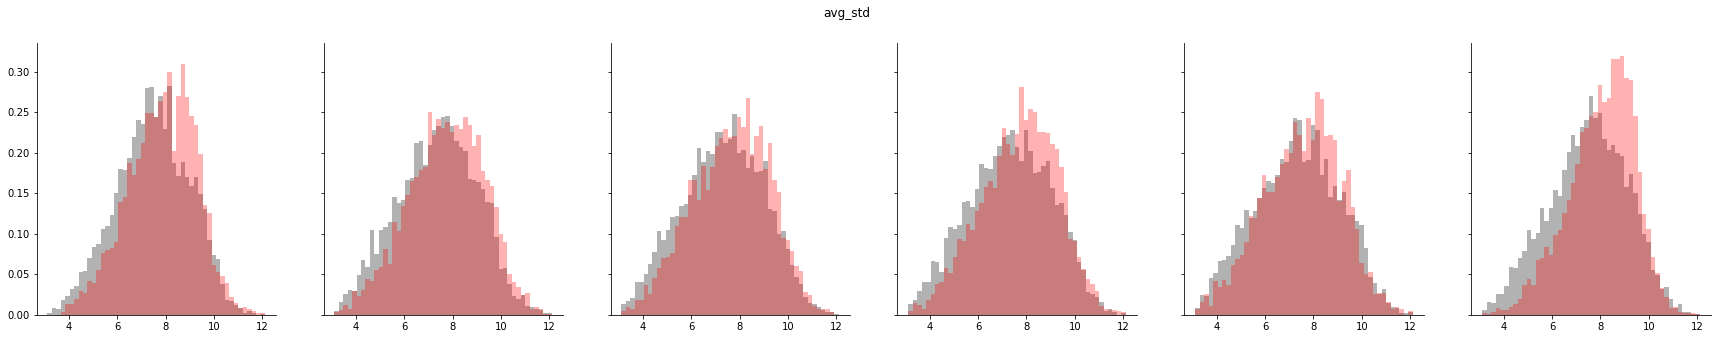

In [27]:
fig, ax = nov_cell_stats.combined_hist('avg_std', cumulative=True, smooth=True, fill = False)
fig.savefig(os.path.join(figdir, 'nov_avg_std_cumhist.pdf'),format = 'pdf')
fig, ax = nov_cell_stats.combined_hist('avg_std', cumulative=False, smooth=False, fill = True)
fig.savefig(os.path.join(figdir, 'nov_avg_std_hist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0      ko_ctrl  22.725388    1   14  22.725388  19.324054  0.000610  0.579883   
1          day   1.694244    5   70   0.338849   5.261726  0.000369  0.273170   
2  Interaction   0.577213    5   70   0.115443   1.792620  0.125604  0.113510   

       eps  
0      NaN  
1  0.73854  
2      NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  5.044007  6.024783 -0.980776  0.102306 -9.586674    0.001 -1.956563
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
0  0  1  5.099171  5.954197 -0.855025  0.27128 -3.151817  0.007065 -1.501728
Day 1
   A  B   mean(A)   mean(B)    diff        se         T   p-tukey    hedges
0  0  1  5.011771  5.919171 -0.9074  0.260082 -3.488898  0.003615 -1.662335
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tuke

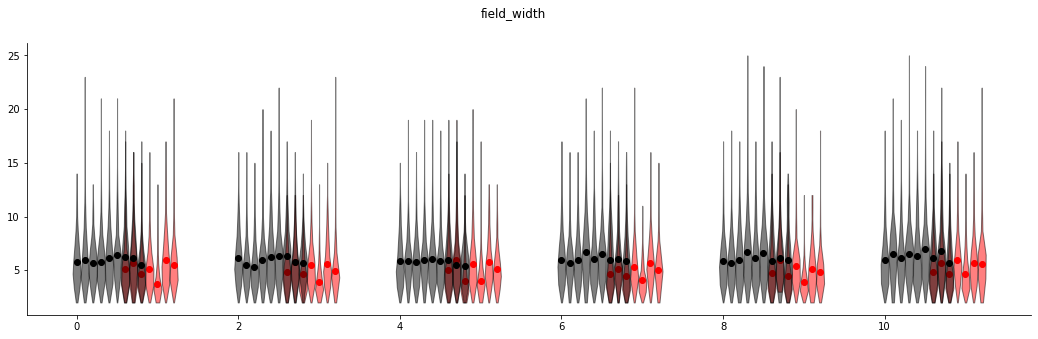

In [28]:
fig,ax = nov_cell_stats.violin_plots('field_width')
nov_cell_stats.mixed_anova('field_width')
fig.savefig(os.path.join(figdir, 'nov_field_width_violin.pdf'),format = 'pdf')

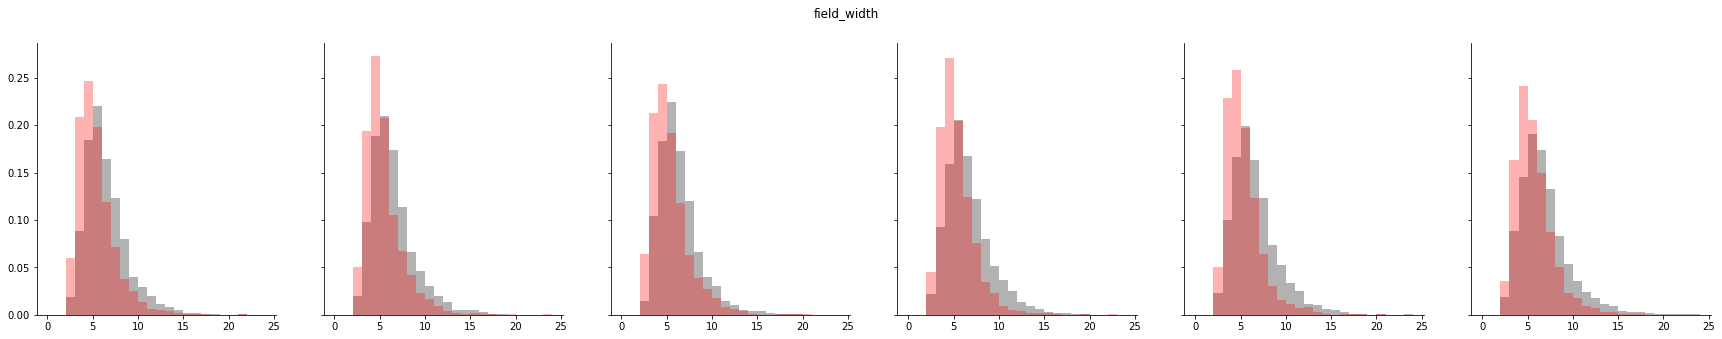

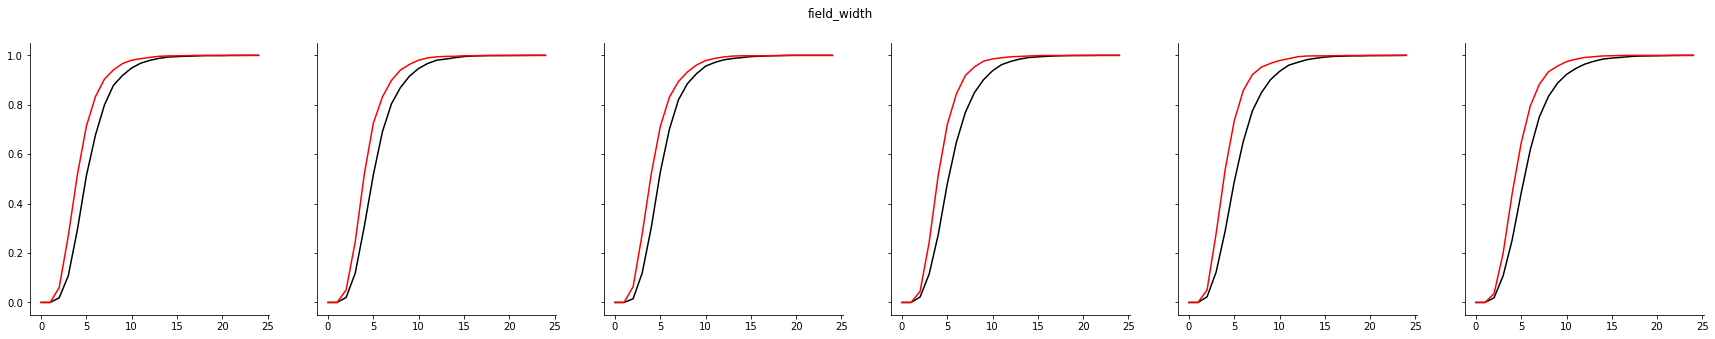

In [29]:
fig, ax = nov_cell_stats.combined_hist('field_width', cumulative=False, smooth=False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'nov_field_width_hist.pdf'),format = 'pdf')
fig, ax = nov_cell_stats.combined_hist('field_width', cumulative=True, smooth=True, fill = False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'nov_field_width_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  8.839904    1    8  8.839904  14.135573  0.005546  0.638591   
1          day  0.862700    5   40  0.172540   3.473845  0.010612  0.302762   
2  Interaction  0.085674    5   40  0.017135   0.344987  0.882414  0.041341   

      eps  
0     NaN  
1  0.7302  
2     NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)  mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.785466  2.01779  0.767676  0.095521  8.036766    0.001  2.048135
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
0  0  1  2.916478  2.173431  0.743047  0.25981  2.859967  0.021155  1.633757
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey   hedges
0  0  1  2.812419  2.064347  0.748072  0.201857  3.705942  0.005991  2.11702
Day 2
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  8.839904    1    8  8.839904  14.135573  0.005546  0.638591   
 1          day  0.862700    5   40  0.172540   3.473845  0.010612  0.302762   
 2  Interaction  0.085674    5   40  0.017135   0.344987  0.882414  0.041341   
 
       eps  
 0     NaN  
 1  0.7302  
 2     NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)  mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  2.785466  2.01779  0.767676  0.095521  8.036766    0.001  2.048135,
 'day_tukey': [   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
  0  0  1  2.916478  2.173431  0.743047  0.25981  2.859967  0.021155  1.633757,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey   hedges
  0  0  1  2.812419  2.064347  0.748072  0.201857  3.705942  0.005991  2.11702,
     A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
  0  0  1  2.941739  2.018149  0.9

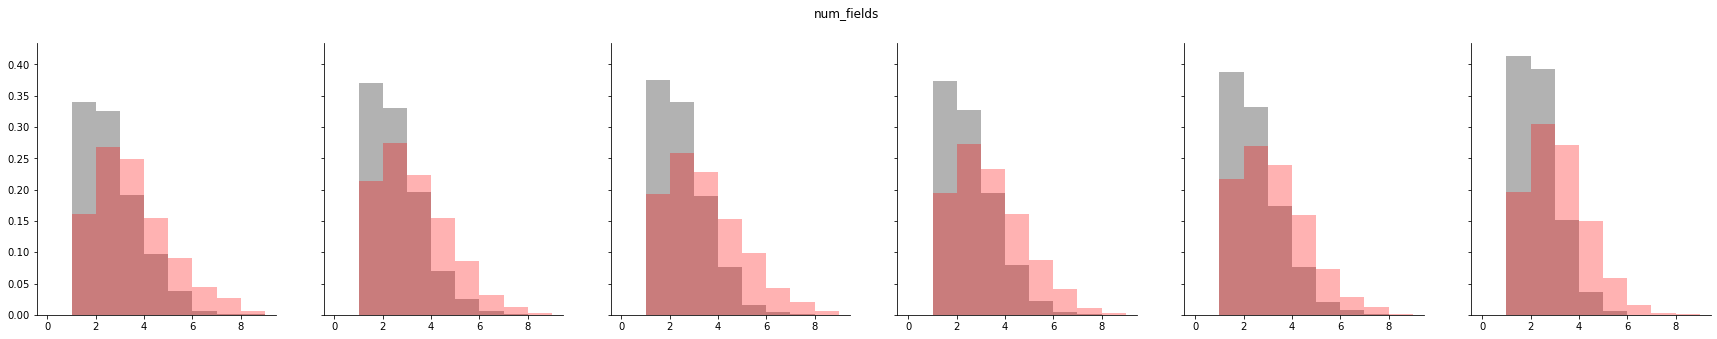

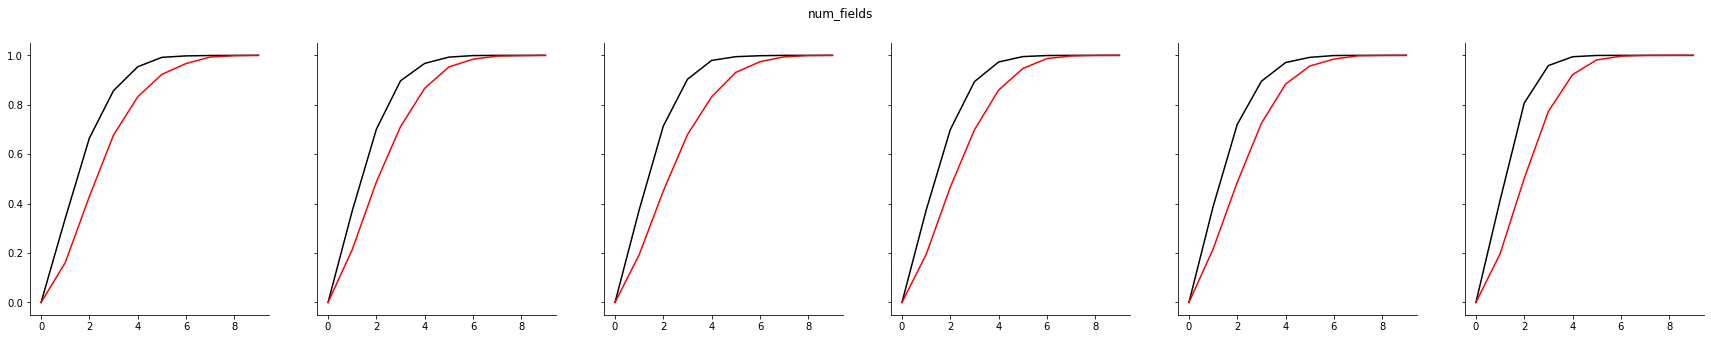

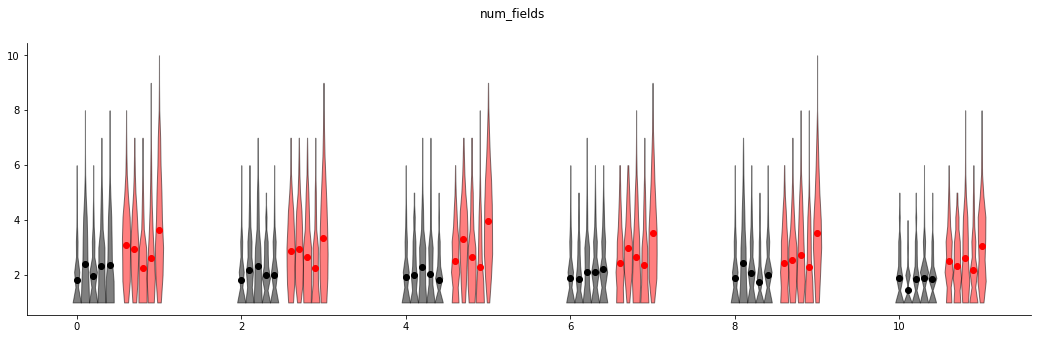

In [38]:
fig, ax = nov_cell_stats.combined_hist('num_fields', cumulative=False, smooth=False, bins = np.arange(0,10))
fig.savefig(os.path.join(figdir, 'nov_num_fields_hist.pdf'),format = 'pdf')
fig, ax = nov_cell_stats.combined_hist('num_fields', cumulative=True, smooth=True, fill = False, bins = np.arange(0,10))
fig.savefig(os.path.join(figdir, 'nov_num_fields_cumhist.pdf'),format = 'pdf')
fig,ax = nov_cell_stats.violin_plots('num_fields')
nov_cell_stats.mixed_anova('num_fields')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.211120    1    8  0.211120  5.227719  0.051552  0.395209   
1          day  0.004540    5   40  0.000908  0.229448  0.947459  0.027881   
2  Interaction  0.004314    5   40  0.000863  0.218001  0.952759  0.026527   

        eps  
0       NaN  
1  0.664937  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  0.028005 -0.090632  0.118637  0.023738  4.997737    0.001  1.273652
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  0.035638 -0.078926  0.114564  0.047205  2.426936  0.041401  1.386388
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  0.025617 -0.092272  0.117889  0.068367  1.724357  0.122929  0.985039
Day 2
   A  B   mean(A)   mean(B)      diff        se       T   p-tukey   

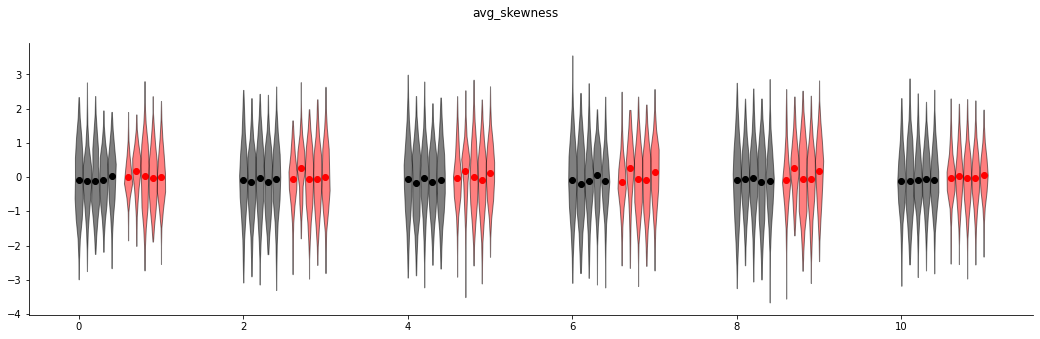

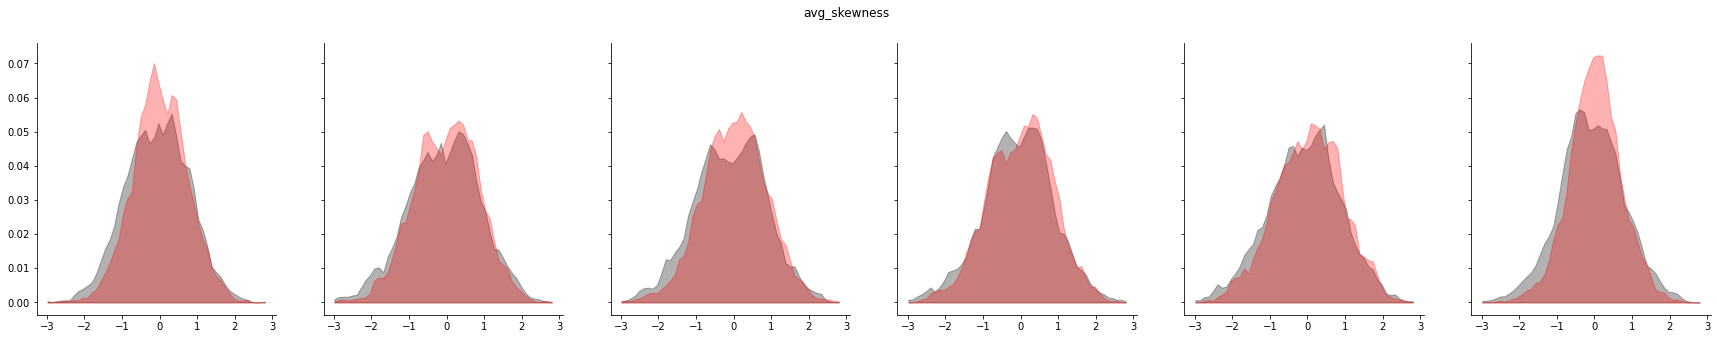

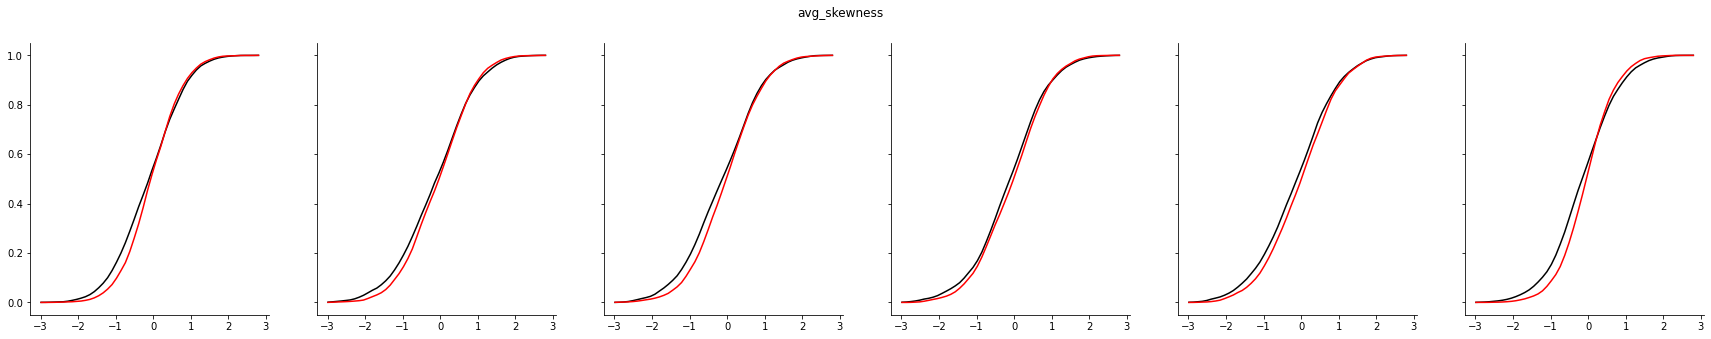

In [41]:
nov_cell_stats.mixed_anova('avg_skewness')
fig, ax = nov_cell_stats.violin_plots('avg_skewness')

fig, ax = nov_cell_stats.combined_hist('avg_skewness', cumulative=False, smooth=True, fill = True)
fig.savefig(os.path.join(figdir, 'nov_avg_skewness.pdf'),format = 'pdf')
fig, ax = nov_cell_stats.combined_hist('avg_skewness', cumulative=True, smooth=True, fill = False)

fig.savefig(os.path.join(figdir, 'nov_avg_skewness_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  2.695590    1    8  2.695590  9.578240  0.014780  0.544892   
1          day  1.756275    5   40  0.351255  8.914741  0.000009  0.527040   
2  Interaction  0.087548    5   40  0.017510  0.444387  0.814746  0.052625   

        eps  
0       NaN  
1  0.500399  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.866806  3.290724 -0.423917  0.080739 -5.250481    0.001 -1.338062
PostHov Tukey on each day
Day 0
   A  B  mean(A)  mean(B)     diff        se         T   p-tukey    hedges
0  0  1  2.62799  3.05683 -0.42884  0.215956 -1.985777  0.082308 -1.134375
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.878367  3.336915 -0.458548  0.147851 -3.101421  0.014632 -1.771687
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hed

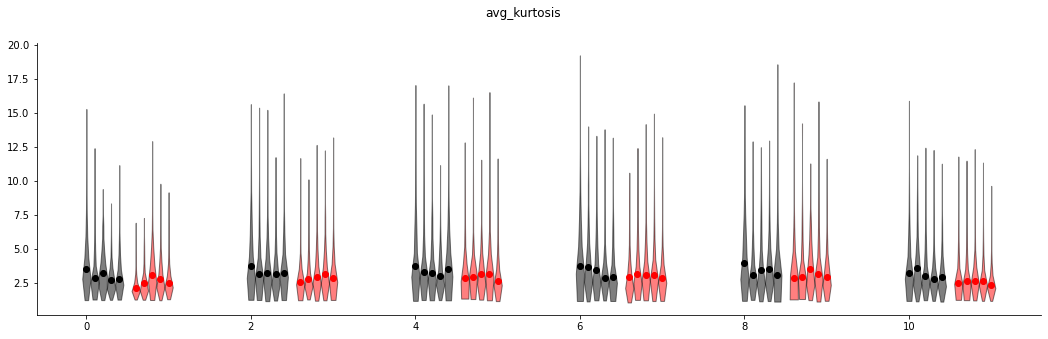

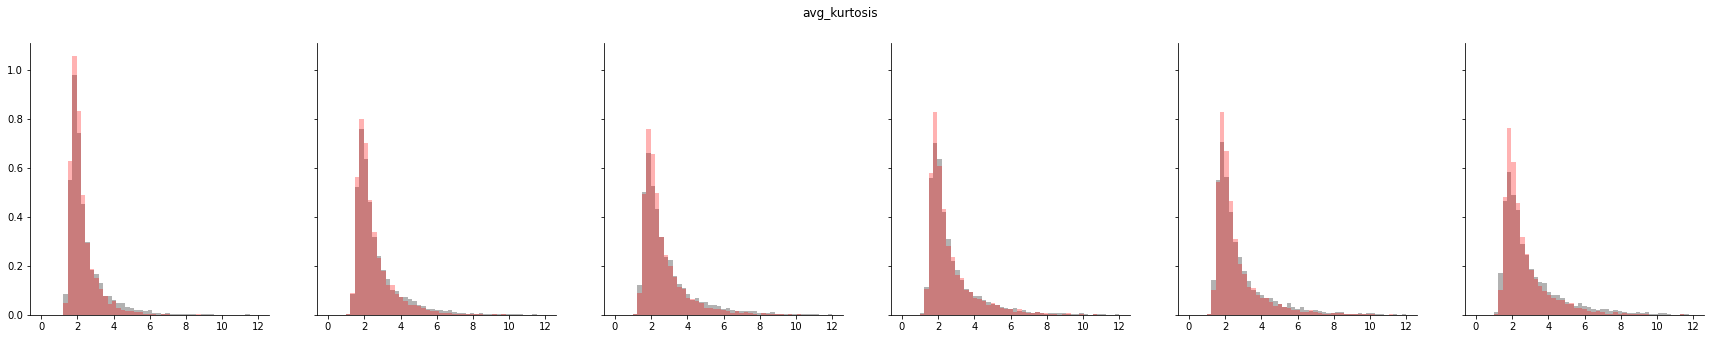

In [34]:
nov_cell_stats.mixed_anova('avg_kurtosis')
fig, ax = nov_cell_stats.violin_plots('avg_kurtosis')
fig, ax = fam_cell_stats.combined_hist('avg_kurtosis', cumulative=False, smooth=False, bins = np.linspace(0,12))

/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:334: RuntimeWarning: Mean of empty slice
  ko_mu, ko_sem = np.nanmean(ko_mu_arr, axis=0), sp.stats.sem(ko_mu_arr, axis=0, nan_policy='omit')
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:335: RuntimeWarning: Mean of empty slice
  ctrl_mu, ctrl_sem = np.nanmean(ctrl_mu_arr, axis=0), sp.stats.sem(ctrl_mu_arr, axis=0, nan_policy='omit')


(<Figure size 2160x720 with 12 Axes>,
 array([[<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>],
        [<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>]], dtype=object))

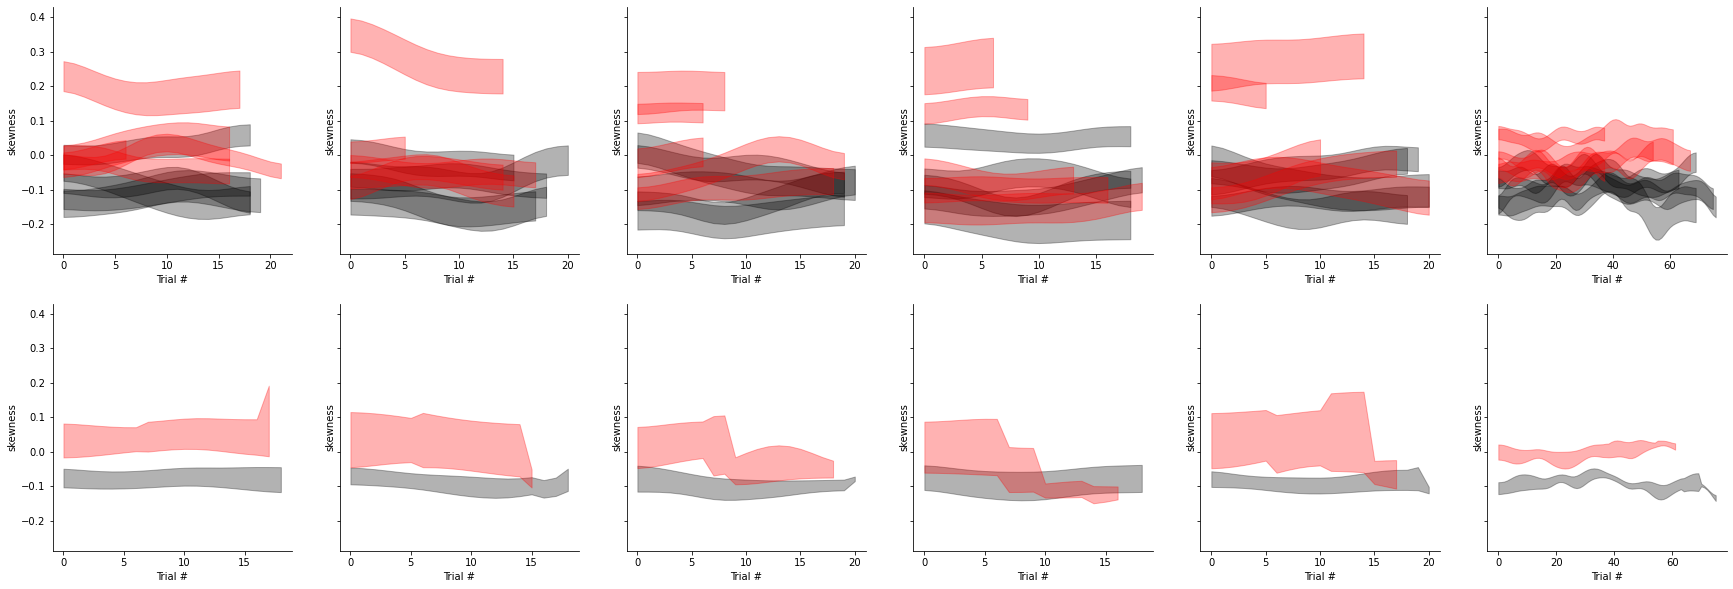

In [35]:
nov_cell_stats.across_trial_plot('skewness')